<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
#For use during testing:
#!pip install leidenalg
#!pip install --index-url https://test.pypi.org/simple/ modisco

!pip install modisco

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
import os

## Grab the input data

In [4]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [3]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict
import numpy as np

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = len(fasta_sequences) #100 #since this is just a test run, for speed I am limiting to 100 sequences
#reverse-complement some of the sequences to simulate that
take_rc = (np.random.RandomState(1234).uniform(size=n) > 0.5)
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                            for x,rc in zip(f['contrib_scores'][task][:n], take_rc)]
    task_to_hyp_scores[task] = [np.array(x) if not rc else np.array(x)[::-1,::-1]
                                for x,rc in zip(f['hyp_contrib_scores'][task][:n], take_rc)]

onehot_data = [one_hot_encode_along_channel_axis(seq) if not rc else
               one_hot_encode_along_channel_axis(seq)[::-1,::-1]
               for seq,rc in zip(fasta_sequences[:n], take_rc)]

Double check by plotting

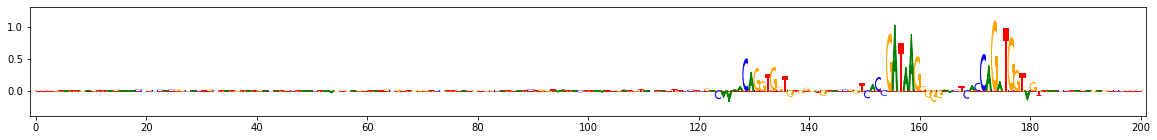

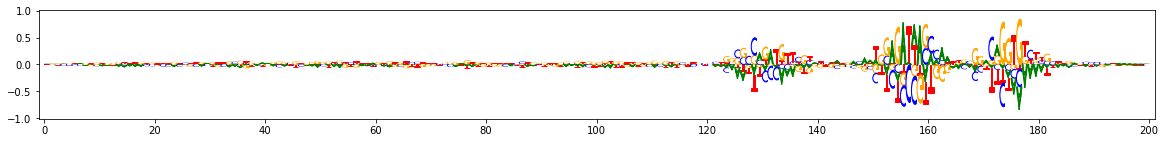

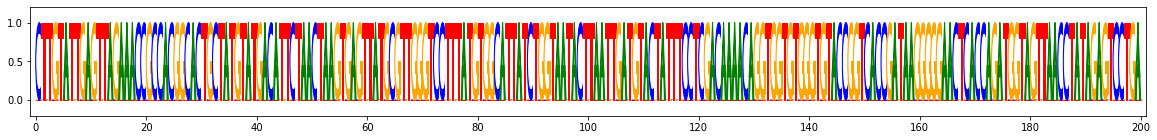

In [7]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. If all three tasks are specified under "task_names", then there will be 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). If only task0 is specified, there will only be two possible metaclusters (+1 and -1). In recent years, we have moved towards running tfmodisco on a single task at a time, which is why the example below just uses task0 (which turns up both the TAL and GATA motifs).

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 15 rather than the default of 30. After the trimming is done, the motif is expanded on either side by initial_flank_to_add. This is set to 5 rather than the default of 10. At the very end of the pipeline, once the motifs have all been processed (e.g. they have been put through the redundancy reduction and filtering steps), the flanks are expanded even further by final_flank_to_add (this is useful for revealing subtle flanking sequences that may be associated with the motif). By default, final_flank_to_add is set to 0; here, we set it to 5. The final motif length is trim_to_window_size + 2 x initial_flank_to_add + 2 x final_flank_to_add.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.184528896
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02423818802833557
Computing threshold
For increasing = True , the minimum IR precision was 0.39972449540266214 occurring at 9.5367431640625e-07 implying a frac_neg of 0.6659017273589992
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.19755100216745247 occurring at -4.76837158203125e-06 implying a frac_neg of 0.24618511918021832
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.9881415814161301  and  0.8861856460571289 with frac passing 0.1614784946236559
Final raw thresholds are -0.9881415814161301  and  0.8861856460571289
Final transformed thresholds are -0.8458602150537634  and  0.8379905913978495


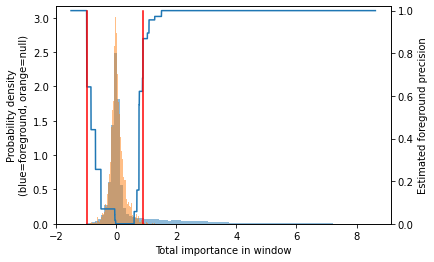

Got 1598 coords
After resolving overlaps, got 1598 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8378905913978495
MEMORY 0.225787904
1598 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [1576]
Idx to activities:  {0: '1'}
MEMORY 0.225837056
On metacluster 0
Metacluster size 1576
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
Using pynnd for nearest neighbor cosine sims
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 1576
(Round 1) Computing coarse affmat
MEMORY 0.225857536
Beginning embedding computation
MEMORY 0.225857536


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   20.2s
[Parallel(n_jobs=10)]: Done 1576 out of 1576 | elapsed:   26.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   13.0s
[Parallel(n_jobs=10)]: Done 1540 tasks      | elapsed:   24.5s
[Parallel(n_jobs=10)]: Done 1576 out of 1576 | elapsed:   25.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1576 out of 1576 | elapsed:    3

Constructing csr matrix...
csr matrix made in 0.24988698959350586 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1576 out of 1576 | elapsed:    3.1s finished


Constructing csr matrix...
csr matrix made in 0.24831199645996094 s
Finished embedding computation in 58.18 s
MEMORY 0.871350272
Starting affinity matrix computations
MEMORY 0.871350272
2021-10-27 18:21:52.240093 Building the index


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2021-10-27 18:22:10.811811 Preparing the index
2021-10-27 18:22:22.748657 Index ready
2021-10-27 18:22:22.749122 Querying neighbors for fwd
2021-10-27 18:22:34.473666 Querying neighbors for rev
2021-10-27 18:22:46.031024 Unifying fwd and rev
Finished affinity matrix computations in 65.53 s
MEMORY 1.033527296
(Round 1) Computed coarse affmat
MEMORY 1.033531392
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 1.033531392
Launching nearest neighbors affmat calculation job
MEMORY 1.041399808
Parallel runs completed
MEMORY 1.058209792
Job completed in: 12.32 s
MEMORY 1.058185216
Launching nearest neighbors affmat calculation job
MEMORY 1.058213888
Parallel runs completed
MEMORY 1.069805568
Job completed in: 11.98 s
MEMORY 1.069658112
(Round 1) Computed affinity matrix on nearest neighbors in 24.74 s
MEMORY 1.082810368
Filtered down to 1501 of 1576
(Round 1) Retained 1501 rows out of 1576 after filtering
MEMORY 1.082904576
(Round 1) Computing density adapted affmat
MEMORY 1.08

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s


Quality: 0.44182685921163156
Got 4 clusters after round 1
Counts:
{0: 456, 2: 341, 1: 386, 3: 318}
MEMORY 1.26420992
(Round 1) Aggregating seqlets in each cluster
MEMORY 1.26420992
Aggregating for cluster 0 with 456 seqlets
MEMORY 1.26420992
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 1 seqlets that went over the sequence edge during flank expansion


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   10.9s finished


Skipped 68 seqlets that went over sequence edge during flank expansion
Skipped 25 due to duplicates
Trimming eliminated 0 seqlets out of 358
Skipped 30 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 1 with 386 seqlets
MEMORY 1.264214016
Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 62 seqlets that went over sequence edge during flank expansion
Skipped 18 due to duplicates
Trimming eliminated 0 seqlets out of 305
Skipped 11 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 2 with 341 seqlets
MEMORY 1.264214016
Skipped 2 seqlets that went over the sequence edge during flank expansion
Skipped 41 seqlets that went over sequence edge during flank expansion
Skipped 16 due to duplicates
Trimming eliminated 0 seqlets out of 282
Skipped 23 seqlets that went over the sequence edge during flank expansion
Aggregating for cluster 3 with 318 seqlets
MEMORY 1.264214016
Skipped 1 seqlets 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done 1140 out of 1140 | elapsed:   16.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:   12.9s
[Parallel(n_jobs=10)]: Done 1140 out of 1140 | elapsed:   17.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:    2.3s finished


Constructing csr matrix...
csr matrix made in 0.175156831741333 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:    2.3s finished


Constructing csr matrix...
csr matrix made in 0.17459583282470703 s
Finished embedding computation in 39.53 s
MEMORY 1.284173824
Starting affinity matrix computations
MEMORY 1.284173824
2021-10-27 18:24:17.005027 Building the index
2021-10-27 18:24:20.195617 Preparing the index
2021-10-27 18:24:21.583830 Index ready
2021-10-27 18:24:21.584425 Querying neighbors for fwd
2021-10-27 18:24:29.344934 Querying neighbors for rev
2021-10-27 18:24:37.110176 Unifying fwd and rev
Finished affinity matrix computations in 20.9 s
MEMORY 1.290330112
(Round 2) Computed coarse affmat
MEMORY 1.290330112
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 1.290330112
Launching nearest neighbors affmat calculation job
MEMORY 1.290330112
Parallel runs completed
MEMORY 1.294536704
Job completed in: 8.67 s
MEMORY 1.294413824
Launching nearest neighbors affmat calculation job
MEMORY 1.294413824
Parallel runs completed
MEMORY 1.29488896
Job completed in: 8.47 s
MEMORY 1.294741504
(Round 2) Computed

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.4s


Quality: 0.29730312620046817
Got 3 clusters after round 2
Counts:
{0: 544, 1: 312, 2: 284}
MEMORY 1.359798272
(Round 2) Aggregating seqlets in each cluster
MEMORY 1.359798272
Aggregating for cluster 0 with 544 seqlets
MEMORY 1.359798272


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    9.0s finished


Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 543
Aggregating for cluster 1 with 312 seqlets
MEMORY 1.359798272
Trimming eliminated 0 seqlets out of 312
Aggregating for cluster 2 with 284 seqlets
MEMORY 1.359802368
Trimming eliminated 0 seqlets out of 284
Got 3 clusters
Splitting into subclusters...
MEMORY 1.359802368
Inspecting pattern 0 for spurious merging


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 543 out of 543 | elapsed:    0.4s finished


[t-SNE] Computed conditional probabilities for sample 543 / 543
[t-SNE] Mean sigma: 0.240252
Beginning preprocessing + Leiden
Affmat shape: 543


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.5s


Quality: 0.3916268472435881
Quality: 0.39577252938634155
Quality: 0.39610216870859793
Quality: 0.39610493781038014
Got subclusters: Counter({0: 174, 1: 120, 2: 115, 3: 85, 4: 49})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.9s finished


Numbers for each pattern pre-subsample: [174, 120, 115, 85, 49]
Numbers after subsampling: [174, 120, 115, 85, 49]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.5429449081420898 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.3976259231567383 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.35916900634765625 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.30238914489746094 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.1927509307861328 s
Cluster sizes
[174 120 115  85  49]
Cross-contamination matrix:
[[1.   0.74 0.7  0.74 0.41]
 [0.59 1.   0.73 0.83 0.48]
 [0.63 0.82 1.   0.84 0.45]
 [0.65 0.88 0.81 1.   0.47]
 [0.59 0.77 0.69 0.7  1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.97 0.98 0.98 0.94]
 [0.97 1.   0.98 0.98 0.97]
 [0.98 0.98 1.   0.99 0.95]
 [0.98 0.98 0.99 1.   0.97]
 [0.94 0.97 0.95 0.97 1.  ]]
Collapsing 2 & 3 with crosscontam 0.805479241409216 and sim 0.9948790080207285
Collapsing 1 & 3 with 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 312 out of 312 | elapsed:    0.1s finished


Beginning preprocessing + Leiden
Affmat shape: 312


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.7s


Quality: 0.2857838266519133
Quality: 0.2868779683172966
Quality: 0.29062157288120444
Got subclusters: Counter({0: 69, 1: 67, 2: 65, 3: 46, 4: 40, 5: 13, 6: 7, 7: 5})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2.7s finished


Numbers for each pattern pre-subsample: [69, 67, 65, 46, 40, 13, 7, 5]
Numbers after subsampling: [69, 67, 65, 46, 40, 13, 7, 5]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.35543107986450195 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.3550839424133301 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.32367801666259766 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.2629108428955078 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.21786284446716309 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.11303973197937012 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.07482695579528809 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.07328319549560547 s
Cluster sizes
[69 67 65 46 40 13  7  5]
Cross-contamination matrix:
[[1.   0.85 0.8  0.81 0.7  0.05 0.15 0.39]
 [0.81 1.   0.7  0.82 0.69 0.02 0.1  0.43]
 [0.86 0.78 1.   0.84 0.75 0.1  0.09 0.41]
 [0.8  0.84 0.77 1. 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 284 out of 284 | elapsed:    0.1s finished


[t-SNE] Computed conditional probabilities for sample 284 / 284
[t-SNE] Mean sigma: 0.295336
Beginning preprocessing + Leiden
Affmat shape: 284


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.5s


Quality: 0.30753117112102984
Quality: 0.30771613164676465
Got subclusters: Counter({0: 70, 1: 51, 2: 51, 3: 47, 4: 38, 5: 22, 6: 5})
On merging iteration 1


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2.5s finished


Numbers for each pattern pre-subsample: [70, 51, 51, 47, 38, 22, 5]
Numbers after subsampling: [70, 51, 51, 47, 38, 22, 5]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.3383028507232666 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.2587747573852539 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.2626779079437256 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.22198891639709473 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.21691298484802246 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.15630698204040527 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.05919790267944336 s
Cluster sizes
[70 51 51 47 38 22  5]
Cross-contamination matrix:
[[1.   0.69 0.83 0.68 0.56 0.05 0.06]
 [0.86 1.   0.87 0.74 0.68 0.06 0.1 ]
 [0.82 0.67 1.   0.64 0.44 0.   0.01]
 [0.94 0.85 0.92 1.   0.76 0.17 0.2 ]
 [0.84 0.76 0.73 0.7  1.   0.06 0.06]
 [0.08 0.09 0.04 0.07 0.14 1.   0.5 ]
 [0.3  0.38 0

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 550 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 590 out of 590 | elapsed:    0.4s finished
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will 

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 590 samples in 0.006s...
[t-SNE] Computed neighbors for 590 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 590 / 590
[t-SNE] Mean sigma: 0.246577
[t-SNE] Computed conditional probabilities in 0.025s
[t-SNE] Iteration 50: error = 73.5478821, gradient norm = 0.3892928 (50 iterations in 0.074s)
[t-SNE] Iteration 100: error = 76.7520294, gradient norm = 0.3570555 (50 iterations in 0.065s)
[t-SNE] Iteration 150: error = 78.0268326, gradient norm = 0.3436039 (50 iterations in 0.082s)
[t-SNE] Iteration 200: error = 79.1144638, gradient norm = 0.3417614 (50 iterations in 0.066s)
[t-SNE] Iteration 250: error = 79.6339722, gradient norm = 0.3522868 (50 iterations in 0.068s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.633972
[t-SNE] Iteration 300: error = 1.6074889, gradient norm = 0.0042721 (50 iterations in 0.062s)
[t-SNE] Iteration 350: error = 1.4455125, gradient norm = 0.0017585 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.6s


Quality: 0.38304982516849534
Quality: 0.3881654845545921


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s


Got subclusters: Counter({0: 184, 1: 161, 2: 138, 3: 52, 4: 17, 5: 14, 6: 12, 7: 10, 8: 2})
On pattern 1


[Parallel(n_jobs=10)]: Done 544 out of 544 | elapsed:    0.4s finished


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 544 samples in 0.005s...
[t-SNE] Computed neighbors for 544 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 544 / 544
[t-SNE] Mean sigma: 0.265349
[t-SNE] Computed conditional probabilities in 0.022s
[t-SNE] Iteration 50: error = 74.4055634, gradient norm = 0.3870918 (50 iterations in 0.071s)
[t-SNE] Iteration 100: error = 77.9627914, gradient norm = 0.3611500 (50 iterations in 0.065s)
[t-SNE] Iteration 150: error = 76.6145477, gradient norm = 0.3788829 (50 iterations in 0.073s)
[t-SNE] Iteration 200: error = 76.8624878, gradient norm = 0.3641053 (50 iterations in 0.064s)
[t-SNE] Iteration 250: error = 76.3080292, gradient norm = 0.3782807 (50 iterations in 0.068s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.308029
[t-SNE] Iteration 300: error = 1.6032877, gradient norm = 0.0035855 (50 iterations in 0.062s)
[t-SNE] Iteration 350: error = 1.4670708, gradient norm = 0.0016226 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.5s


Quality: 0.3089385373040786
Quality: 0.3106675456054303
Quality: 0.3107973023053843
Quality: 0.3110599655909164
Quality: 0.3117511241267314
Quality: 0.31188998092521675
Got subclusters: Counter({0: 129, 1: 101, 2: 93, 3: 84, 4: 80, 5: 29, 6: 17, 7: 11})


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.9s finished


In [5]:
import h5py
import numpy as np
%matplotlib inline
import modisco

#Uncomment to refresh modules for when tweaking code during development:
from importlib import reload
reload(modisco.util)
reload(modisco.pattern_filterer)
reload(modisco.aggregator)
reload(modisco.core)
reload(modisco.affinitymat.transformers)
reload(modisco.affinitymat.core)
reload(modisco.affinitymat)
reload(modisco.cluster.core)
reload(modisco.cluster)
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
reload(modisco)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        final_flank_to_add=5,
                        final_min_cluster_size=60,
                        use_pynnd=True, #use_pynnd=True can be used for better
                        n_cores=10)
                )(
                 task_names=["task0"],#, "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores=null_per_pos_scores)

## Save Results

In [6]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


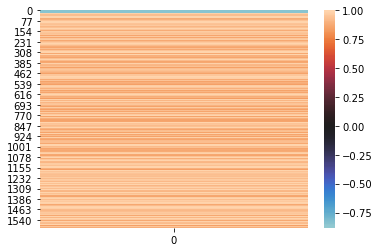

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 590
Task 0 hypothetical scores:


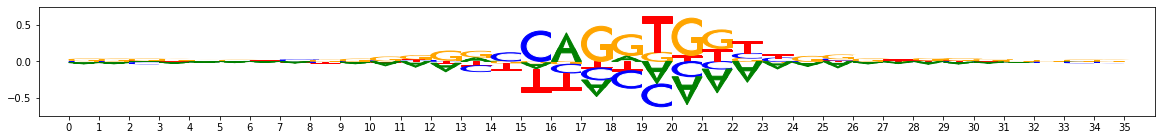

Task 0 actual importance scores:


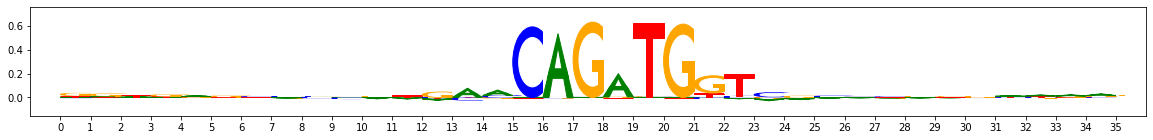

onehot, fwd and rev:


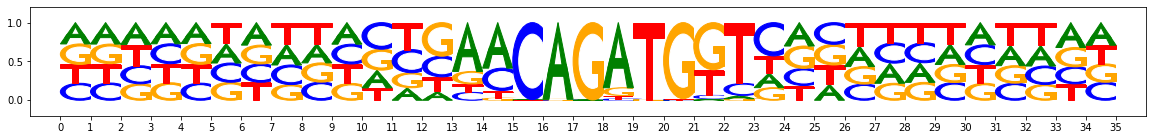

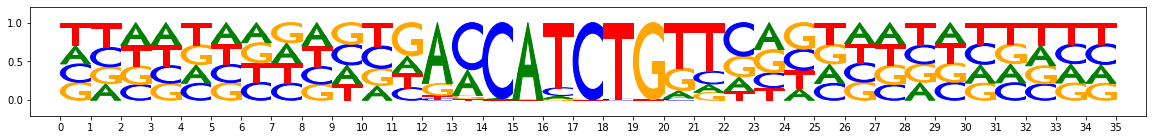

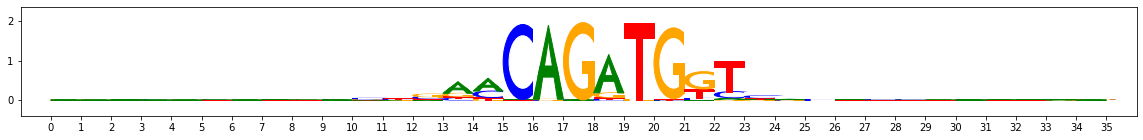

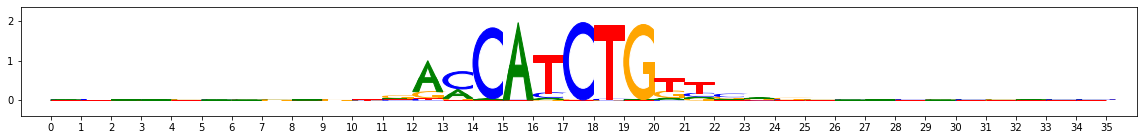

PLOTTING SUBCLUSTERS


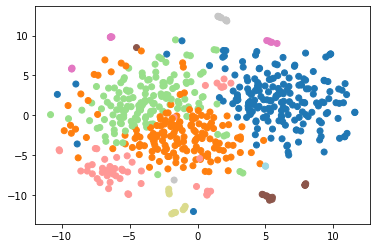

subcluster_0 size 184


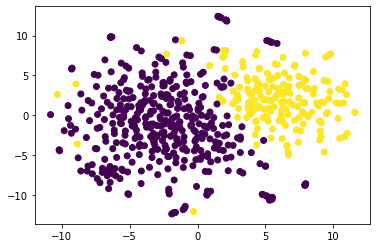

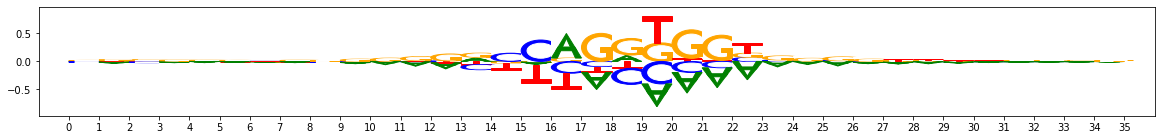

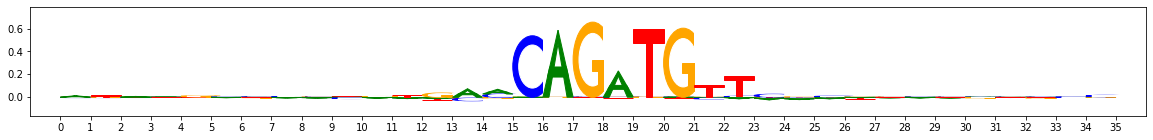

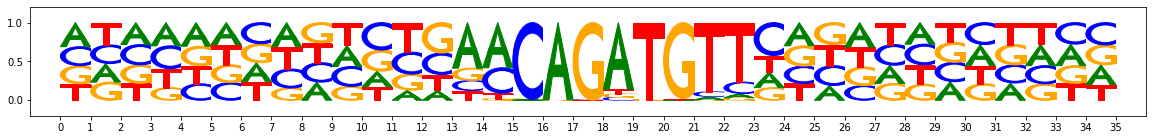

subcluster_1 size 161


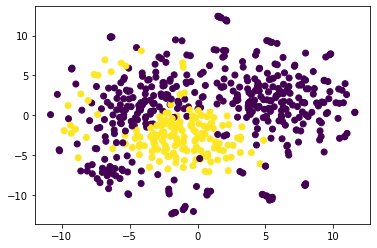

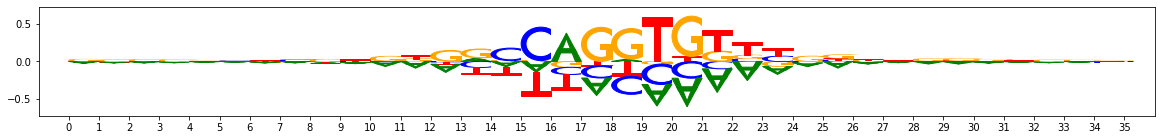

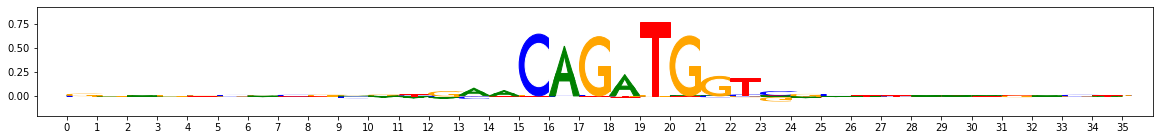

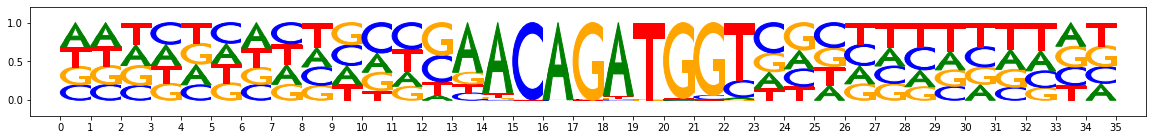

subcluster_2 size 138


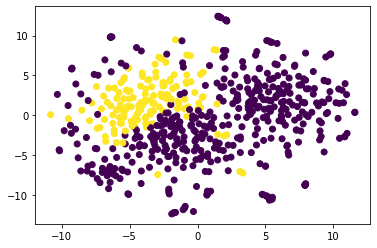

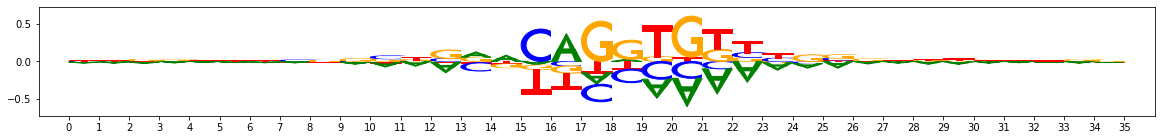

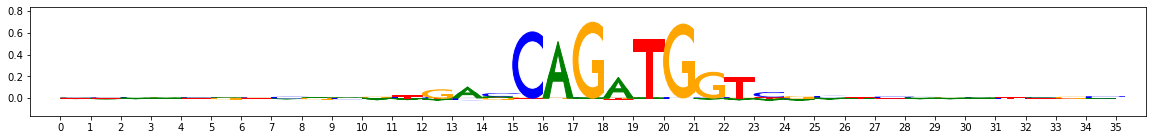

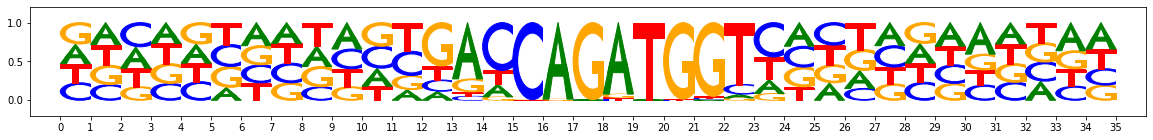

subcluster_3 size 52


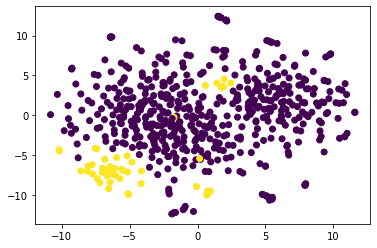

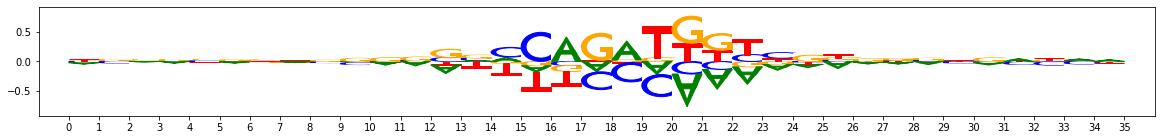

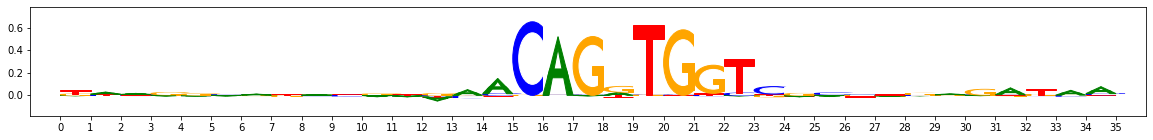

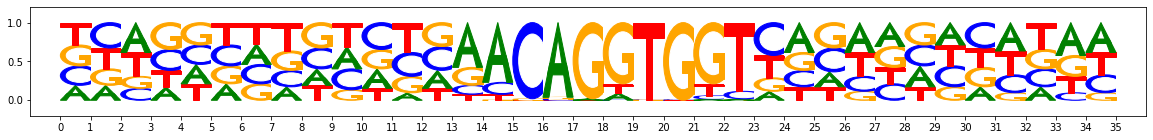

subcluster_4 size 17


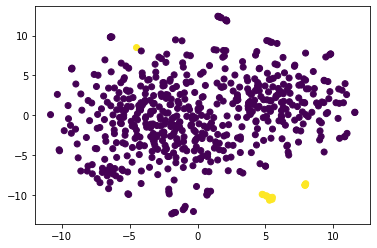

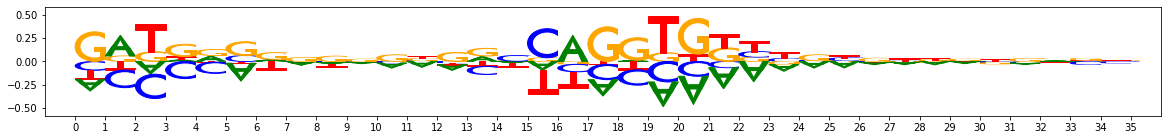

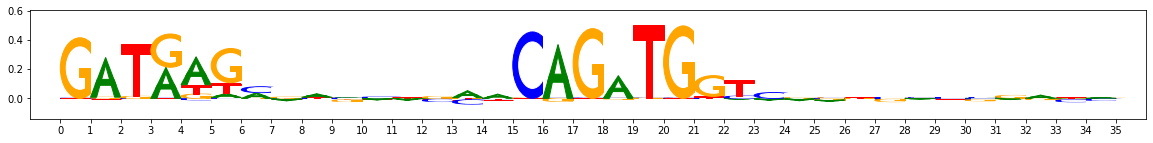

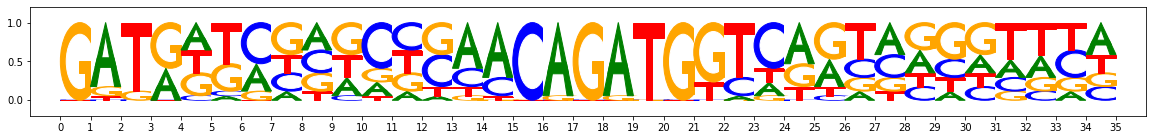

subcluster_5 size 14


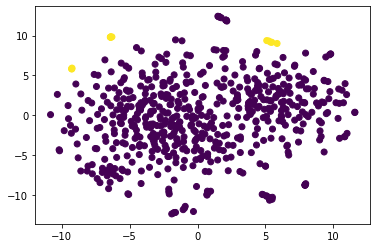

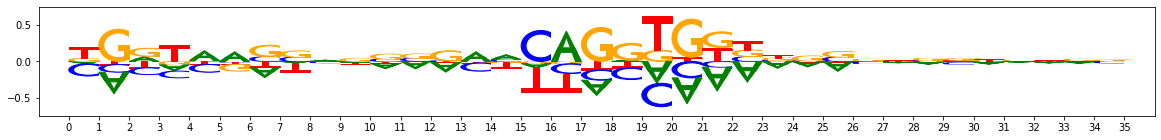

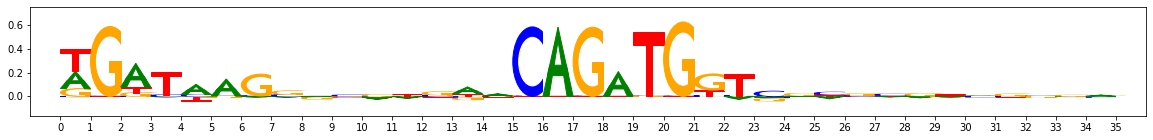

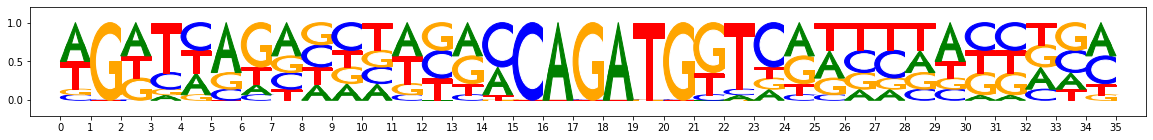

subcluster_6 size 12


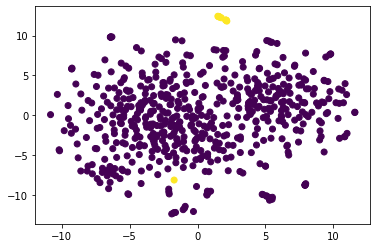

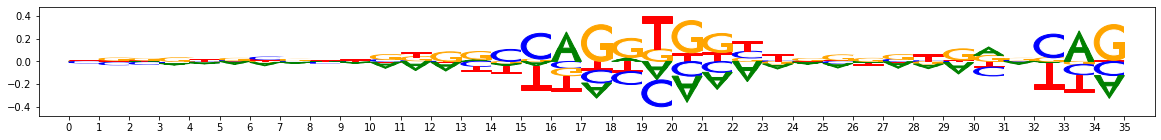

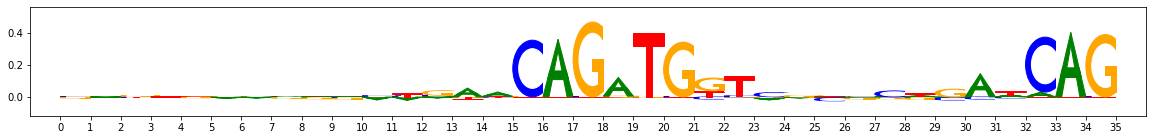

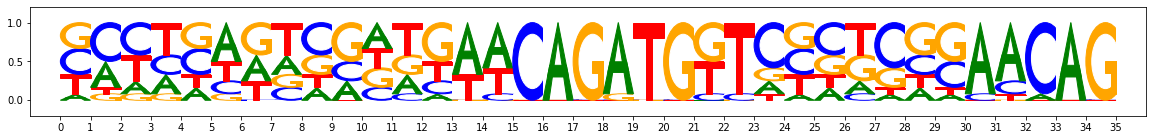

subcluster_7 size 10


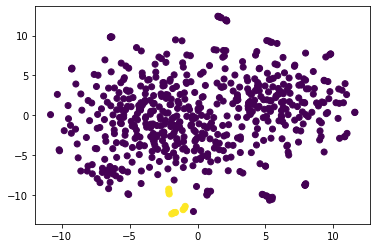

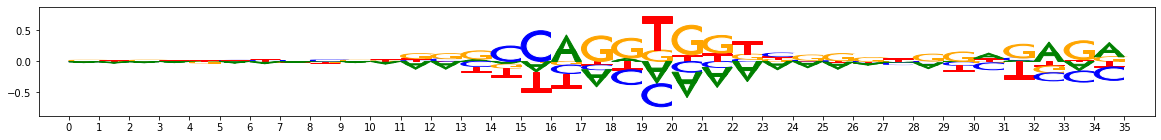

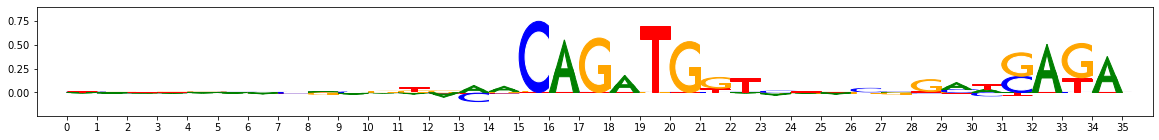

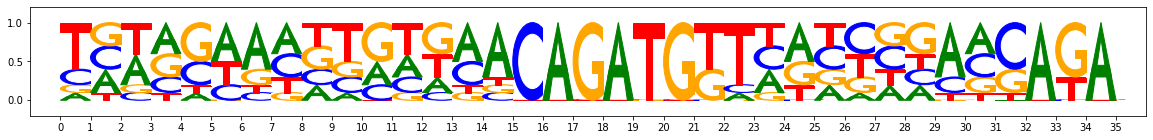

subcluster_8 size 2


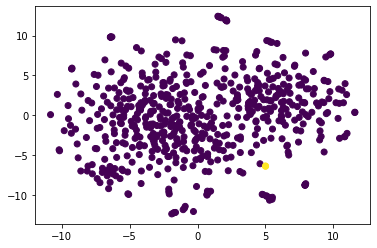

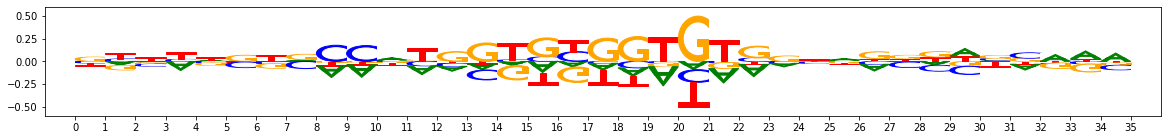

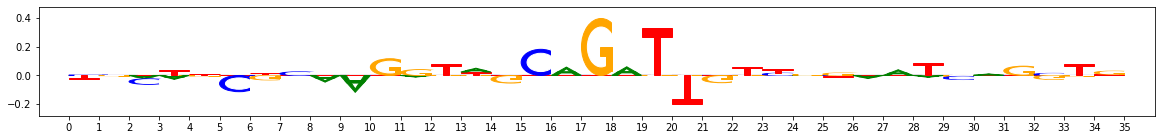

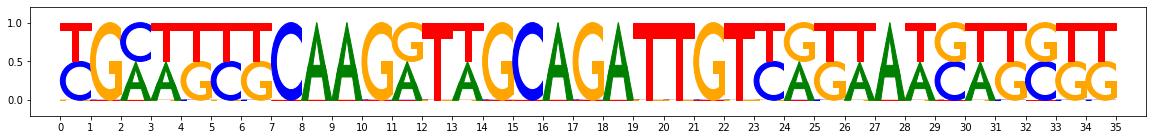

metacluster_0 pattern_1
total seqlets: 544
Task 0 hypothetical scores:


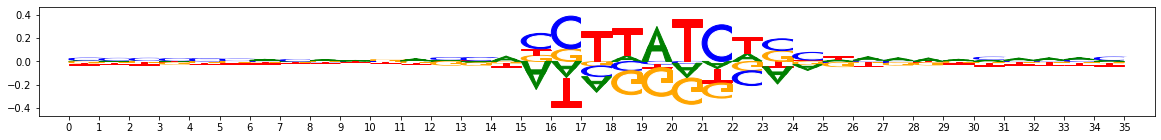

Task 0 actual importance scores:


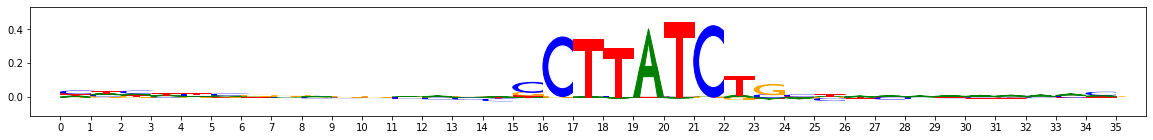

onehot, fwd and rev:


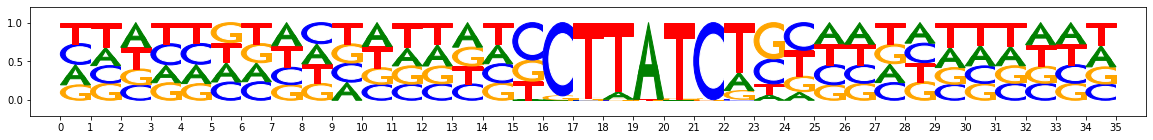

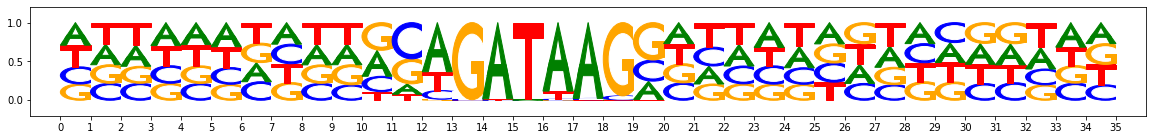

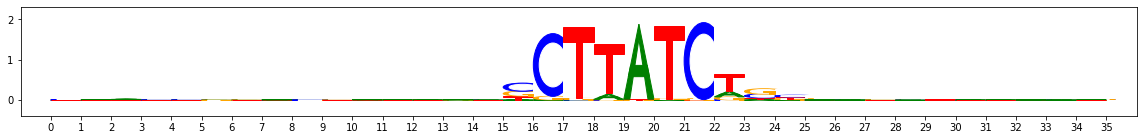

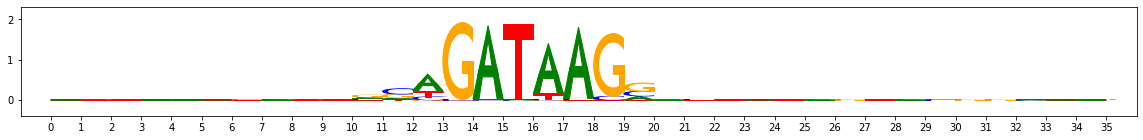

PLOTTING SUBCLUSTERS


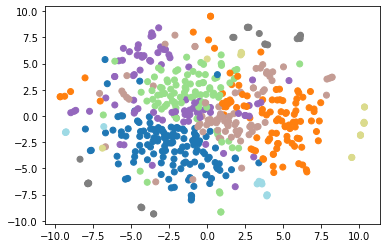

subcluster_0 size 129


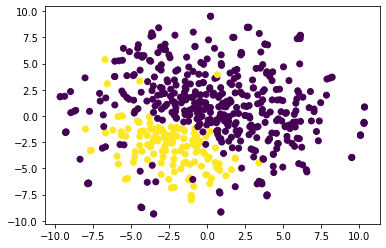

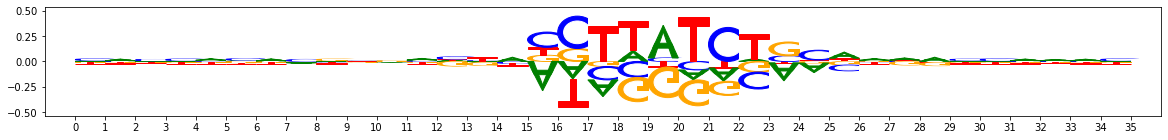

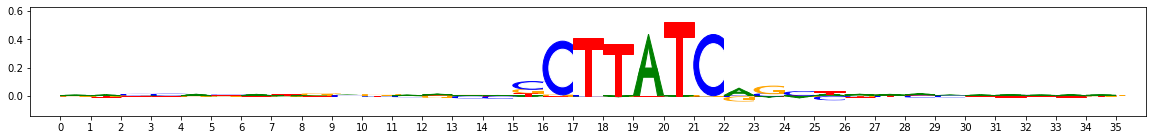

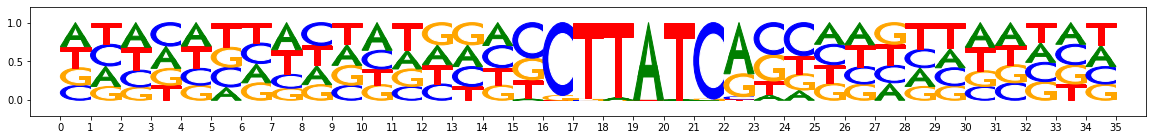

subcluster_1 size 101


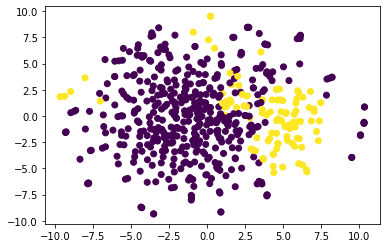

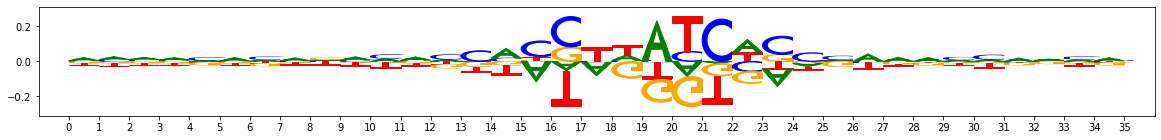

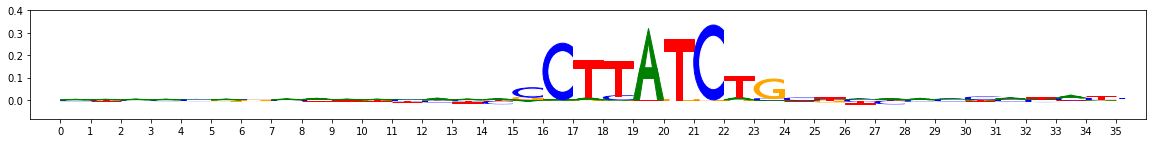

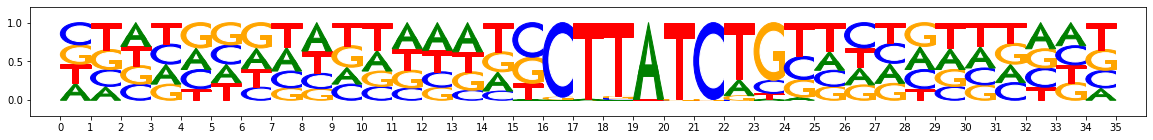

subcluster_2 size 93


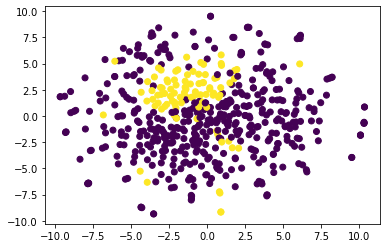

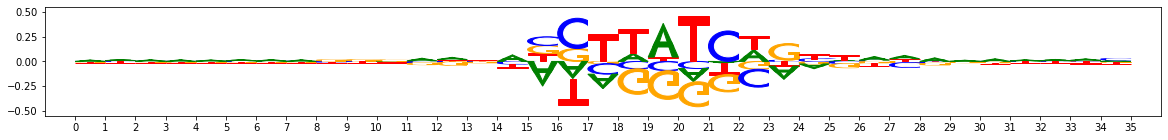

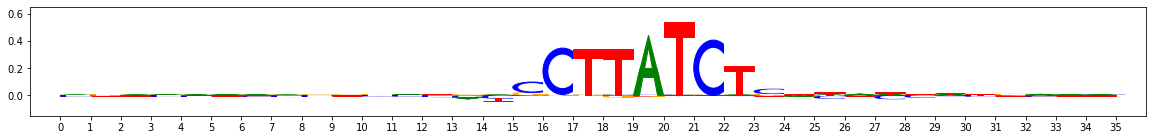

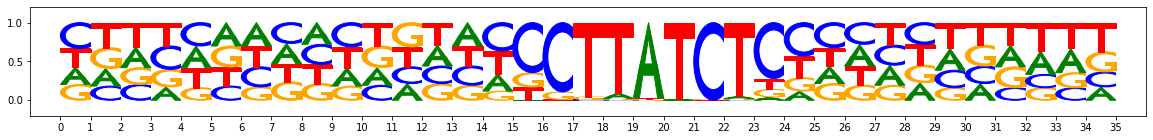

subcluster_3 size 84


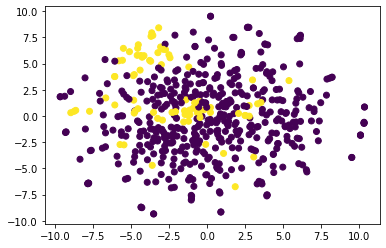

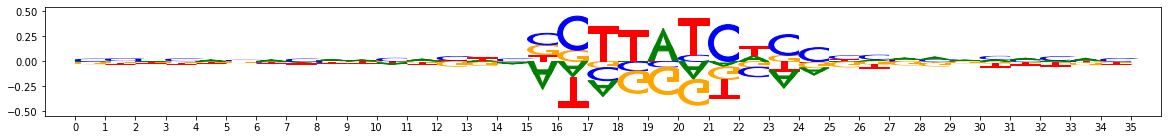

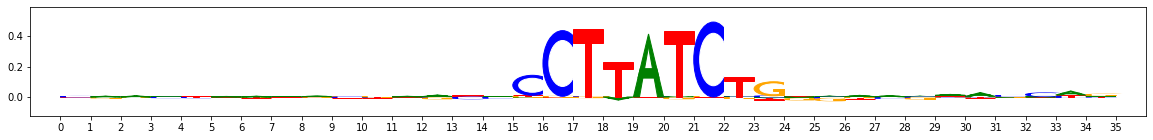

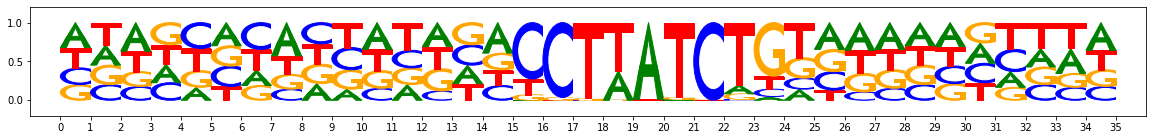

subcluster_4 size 80


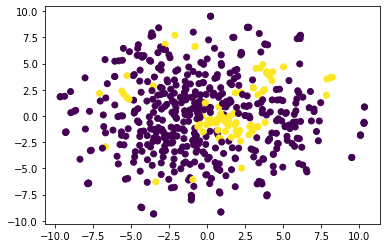

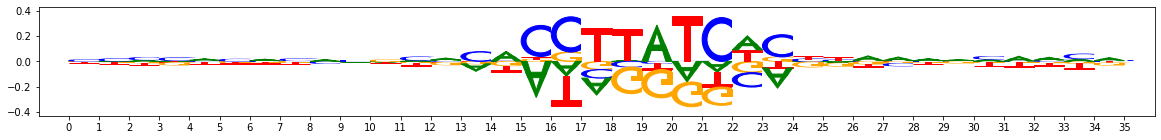

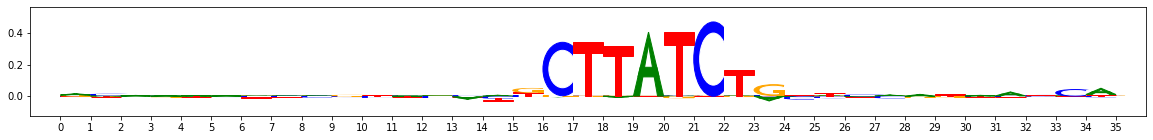

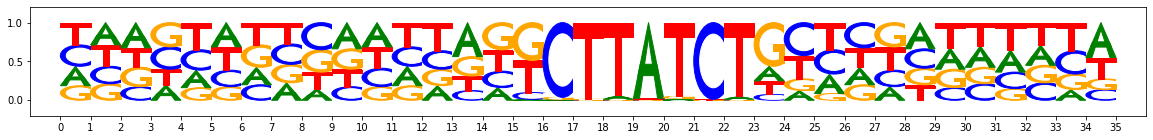

subcluster_5 size 29


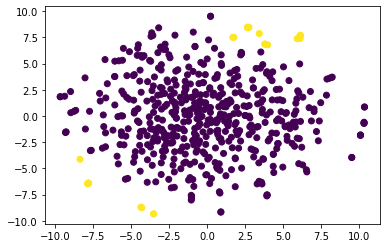

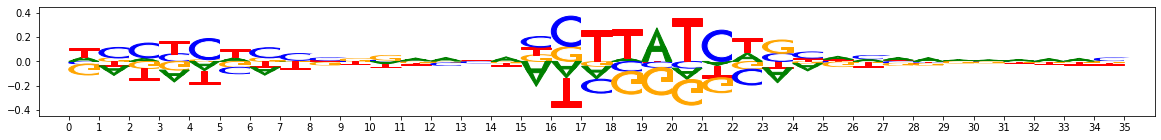

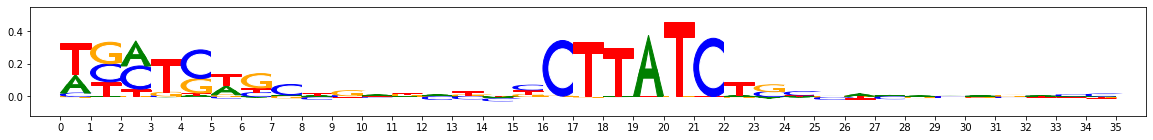

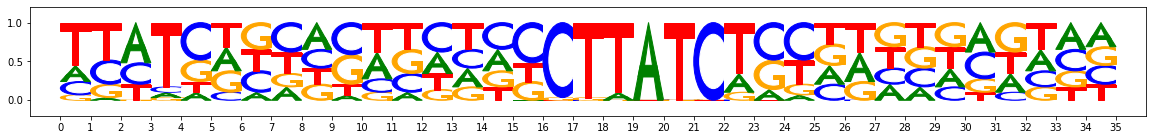

subcluster_6 size 17


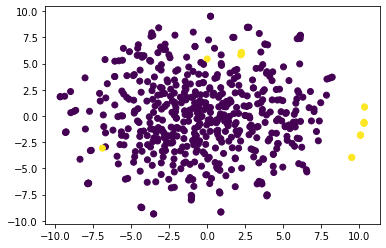

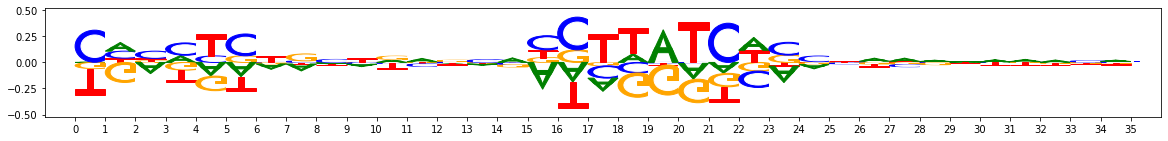

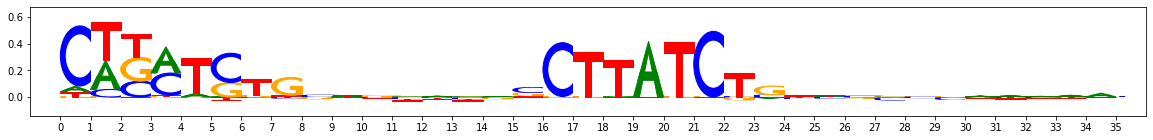

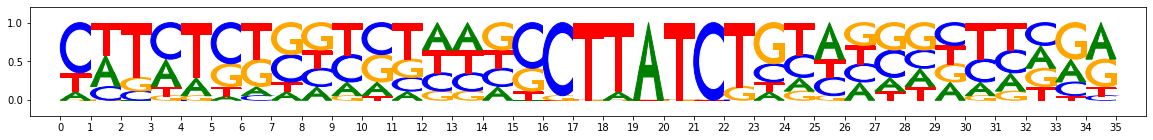

subcluster_7 size 11


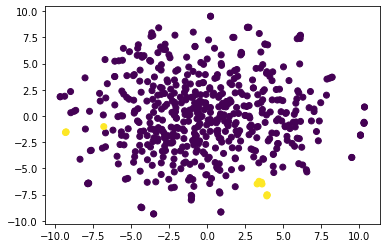

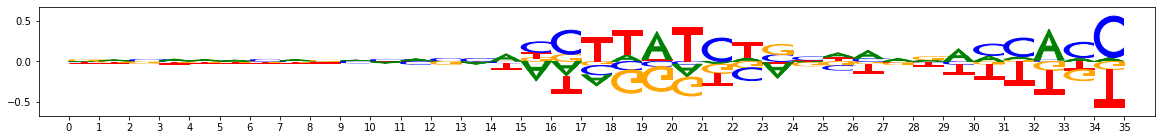

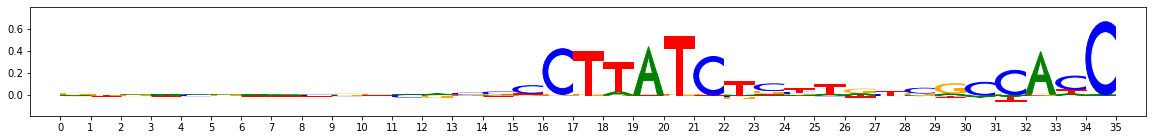

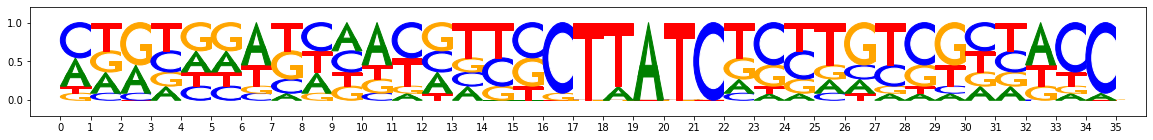

In [8]:
from collections import Counter
import numpy as np

from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.mean(onehot_data, axis=(0,1))

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(pattern["sequence"]["fwd"])
        viz_sequence.plot_weights(pattern["sequence"]["rev"])
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        #Plot the subclustering too, if available
        if ("subclusters" in pattern):
            print("PLOTTING SUBCLUSTERS")
            subclusters = np.array(pattern["subclusters"])
            twod_embedding = np.array(pattern["twod_embedding"])
            plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
            plt.show()
            for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
                subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
                print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
                subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
                plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
                plt.show()
                viz_sequence.plot_weights(subpattern["task0_hypothetical_contribs"]["fwd"])
                viz_sequence.plot_weights(subpattern["task0_contrib_scores"]["fwd"])
                viz_sequence.plot_weights(subpattern["sequence"]["fwd"])
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [9]:
import h5py
import numpy as np
from importlib import reload
import modisco
reload(modisco.util)
reload(modisco.core)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

#If loading from a file for which subclusters haven't been computed (e.g. a file produced by an
# earlier version of modisco), you can compute the subclusters by
# following this template:
#patterns = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results["metacluster_0"]
#            .seqlets_to_patterns_result.patterns)
#for pattern in patterns:
#    pattern.compute_subclusters_and_embedding(
#                 pattern_comparison_settings=modisco.affinitymat.core.PatternComparisonSettings(                         
#                    track_names=["task0_hypothetical_contribs", "task0_contrib_scores"],                      
#                    track_transformer=modisco.affinitymat.L1Normalizer(),
#                    min_overlap=None), #min_overlap argument is irrelevant here    
#                 perplexity=30, n_jobs=4, verbose=True)

## Do hit scoring
The hit scoring strategy is still in development. For the previous hit scoring strategy, see the version at https://github.com/kundajelab/tfmodisco/blob/v0.5.13.2/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA_hitscoring.ipynb

Getting trimmed patterns, subclustering them
Trimming the patterns to the target length
Apply subclustering


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 590 out of 590 | elapsed:    1.4s finished
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed alt

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 590 samples in 0.005s...
[t-SNE] Computed neighbors for 590 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 590 / 590
[t-SNE] Mean sigma: 0.242895
[t-SNE] Computed conditional probabilities in 0.022s
[t-SNE] Iteration 50: error = 71.6931381, gradient norm = 0.4120234 (50 iterations in 0.067s)
[t-SNE] Iteration 100: error = 71.9993591, gradient norm = 0.4211736 (50 iterations in 0.061s)
[t-SNE] Iteration 150: error = 74.4269257, gradient norm = 0.4030931 (50 iterations in 0.085s)
[t-SNE] Iteration 200: error = 76.5435028, gradient norm = 0.3618425 (50 iterations in 0.087s)
[t-SNE] Iteration 250: error = 77.1538544, gradient norm = 0.3318471 (50 iterations in 0.066s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.153854
[t-SNE] Iteration 300: error = 1.5222239, gradient norm = 0.0039425 (50 iterations in 0.055s)
[t-SNE] Iteration 350: error = 1.4454033, gradient norm = 0.0010864 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s


Quality: 0.40344309207916196
Quality: 0.40481055343012484
Quality: 0.40485982547349797
Quality: 0.4048809624471493


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Got subclusters: Counter({0: 193, 1: 176, 2: 142, 3: 55, 4: 24})


[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 544 out of 544 | elapsed:    0.3s finished


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 544 samples in 0.004s...
[t-SNE] Computed neighbors for 544 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 544 / 544
[t-SNE] Mean sigma: 0.262071
[t-SNE] Computed conditional probabilities in 0.019s
[t-SNE] Iteration 50: error = 69.7062531, gradient norm = 0.4502950 (50 iterations in 0.054s)
[t-SNE] Iteration 100: error = 74.6274261, gradient norm = 0.3789878 (50 iterations in 0.088s)
[t-SNE] Iteration 150: error = 74.5429611, gradient norm = 0.3702220 (50 iterations in 0.096s)
[t-SNE] Iteration 200: error = 72.9784622, gradient norm = 0.3890277 (50 iterations in 0.098s)
[t-SNE] Iteration 250: error = 75.1580963, gradient norm = 0.4087066 (50 iterations in 0.095s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.158096
[t-SNE] Iteration 300: error = 1.7148707, gradient norm = 0.0039602 (50 iterations in 0.084s)
[t-SNE] Iteration 350: error = 1.5454150, gradient norm = 0.0018460 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s


Quality: 0.32473889351491425
Quality: 0.3266134563366822
Quality: 0.32854678474553833
Quality: 0.329069117249065
Quality: 0.32936895045211195
Quality: 0.3298006238761977


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished


Got subclusters: Counter({0: 119, 1: 102, 2: 97, 3: 73, 4: 63, 5: 44, 6: 34, 7: 12})
Preparing seqlet scorer
Pattern length (and hence target seqlet size) is 25
Subsampling subpattern 0
Subsampling subpattern 1
Subsampling subpattern 2
Subsampling subpattern 5
Subsampling subpattern 6
Prepare seqlet scorer
Computing best alignments for all motifseqlets
Launching nearest neighbors affmat calculation job
MEMORY 1.378074624
Parallel runs completed
MEMORY 1.3782016
Job completed in: 0.38 s
MEMORY 1.3782016
Launching nearest neighbors affmat calculation job
MEMORY 1.3782016
Parallel runs completed
MEMORY 1.378205696
Job completed in: 0.36 s
MEMORY 1.378205696
On seqlets 0 to 902 out of 902


100%|██████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.60it/s]


0 seqlets out of 902 did not have themselves in their nearest neighbs, likelydue to alignment issues
Insantiating a precision scorer based on fann_perclasssum
Accuracy: 1.0
Insantiating a precision scorer based on fann_perclassavg
Accuracy: 0.9977827050997783
Launching nearest neighbors affmat calculation job
MEMORY 1.379917824
Parallel runs completed
MEMORY 1.379917824
Job completed in: 0.91 s
MEMORY 1.379917824
Launching nearest neighbors affmat calculation job
MEMORY 1.379917824
Parallel runs completed
MEMORY 1.379917824
Job completed in: 0.95 s
MEMORY 1.379917824
On seqlets 0 to 902 out of 902


100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 22.41it/s]

Insantiating a precision scorer based on aggregate sim
Accuracy: 0.41352549889135254
Mapping affinity to distmat
Symmetrizing nearest neighbors


Computing betas for density adaptation
Computing normalizing denominators
Computing density-adapted nn affmat
Beginning preprocessing + Leiden
initclusters length: 902
Affmat shape: 902


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.7s


Quality: 0.36265369815953197
Quality: 0.3626536981595321
Quality: 0.36265369815953513
Quality: 0.3626536981595427
Quality: 0.36265369815954535


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.0s finished


Number of reclustered idxs: 2
{(1, 0), (0, 1)}
Preparing modularity scorer
Accuracy: 1.0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.0074628859525546435
Computing threshold
For increasing = True , the minimum IR precision was 0.30555383567580957 occurring at 1.475214958190918e-06 implying a frac_neg of 0.43999643366619123
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.16537335524525754 occurring at -9.5367431640625e-07 implying a frac_neg of 0.19814051742123928
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.585796594619751  and  0.5206022262573242 with frac passing 0.10880154639175257
Final raw thresholds are -0.585796594619751  and  0.5206022262573242
Final transformed thresholds are -0.8965592783505154  and  0.89


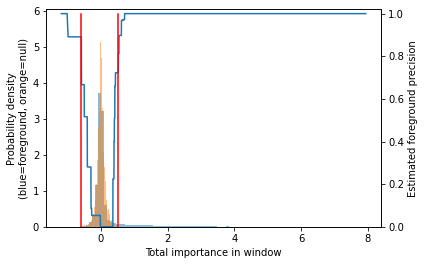

Only returning positive coords!
Got 1803 coords


In [10]:
import modisco
import modisco.util
reload(modisco.util)
reload(modisco.cluster.core)
reload(modisco.coordproducers)
from modisco.visualization import viz_sequence
reload(modisco.aggregator)
from modisco import hit_scoring
reload(modisco.hit_scoring)
from modisco.hit_scoring import densityadapted_hitscoring
reload(modisco.hit_scoring.densityadapted_hitscoring)
reload(densityadapted_hitscoring)
reload(modisco.cluster.core)

orig_patterns = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results["metacluster_0"]
                .seqlets_to_patterns_result.patterns)

#The hit-scorer works in two stages:
# (1) Identifying regions of high importance ("seqlets")
# (2) Mapping those seqlets to patterns (motifs)
#(The two stages are independent of each other)

#instantiate the hit_scorer by providing the patterns
# that identified seqlets will be mapped to. The patterns
# will be trimmed to target_seqlet_size
hit_scorer = densityadapted_hitscoring.MakeHitScorer(
    patterns=orig_patterns,
    target_seqlet_size=25,
    bg_freq=np.mean(onehot_data, axis=(0,1)),
    task_names_and_signs=[("task0",1)],
    n_cores=4)

#set the method used to identify coordinates of high importance ("seqlets")
#You have to provide a contribution score track as this will be used
# to calibrate the threshold used for seqlet identification. You
# can also optionally provide an empirical null distribution track via
# the 'null_track' argument, similar to when tf-modisco is first run.
hit_scorer.set_coordproducer(contrib_scores=task_to_scores,
                             core_sliding_window_size=7,
                             target_fdr=0.2,
                             min_passing_windows_frac=0.03,
                             max_passing_windows_frac=0.2,
                             separate_pos_neg_thresholds=False,                             
                             max_seqlets_total=np.inf)



In [11]:
#Now that the hit-scorer is configured, you can call it on some data to
# get the motif hit calls.
#Note that the values provided to contrib_scores below DO NOT have to be
# the same as the values provided to set_coordproducer above.
#I recommend running this on a small number of regions first to get a feel
# for the runtime; we're still working on improving the runtime here.
(exampleidx_to_matches, patternidx_to_matches) = hit_scorer(
           contrib_scores=task_to_scores,
           hypothetical_contribs=task_to_hyp_scores,
           one_hot=onehot_data,
           hits_to_return_per_seqlet=1)

#Note: if you already have a list of seqlets, you can score them
# using: hit_scorer.seqlet_scorer(seqlets,hits_to_return_per_seqlet=1);
# this will return a 3-tuple of
# (seqlet_matches, patternidx_to_matches, exampleidx_to_matches)

Computing windowed sums on original
Only returning positive coords!
Got 1803 coords
Launching nearest neighbors affmat calculation job
MEMORY 1.380405248
Parallel runs completed
MEMORY 1.380405248
Job completed in: 2.58 s
MEMORY 1.380405248
Launching nearest neighbors affmat calculation job
MEMORY 1.380405248
Parallel runs completed
MEMORY 1.380405248
Job completed in: 2.55 s
MEMORY 1.380405248
On seqlets 0 to 1803 out of 1803


100%|██████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


Launching nearest neighbors affmat calculation job
MEMORY 1.412005888
Parallel runs completed
MEMORY 1.412005888
Job completed in: 1.32 s
MEMORY 1.412005888
Launching nearest neighbors affmat calculation job
MEMORY 1.412005888
Parallel runs completed
MEMORY 1.412005888
Job completed in: 1.33 s
MEMORY 1.412005888
On seqlets 0 to 1803 out of 1803


100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.56it/s]


Removed 3 duplicates


We can now visualize the matches within the sequences.

I am still deciding how to filter out poor-quality matches, and I think some combination of `total_importance` (representing the total importance score in the region of the match), `aggregate_sim` (representing the Continuous Jaccard similarity of the match to the aggregate motif), `fann_perclasssum_perc` (a measure that looks at the percentile rank (relative to the original motif seqlets) of the sum of within-cluster similarities computed at the fine-grained affinity matrix step; fann stands for fine-grained affinity nearest neighbors) and `fann_perclassavg_perc` (a measure that looks at the percentile rank of the *average* within-cluster similarity computed at the fine-grained affinity matrix step) would be useful. Note that although `fann_perclasssum_perc` and `fann_perclassavg_perc` seem identical in the example below, in general they are not, because the number of nearest-neighbors that are within-cluster could vary from one match to the next.

EXAMPLE IDX 0 hits:
Computing windowed sums on original
Only returning positive coords!
Got 3 coords
Original core seqlet locations


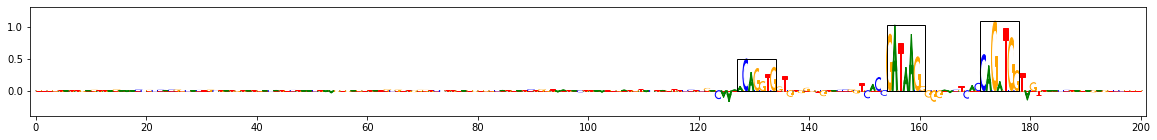

Motif matches (red = without trimming)


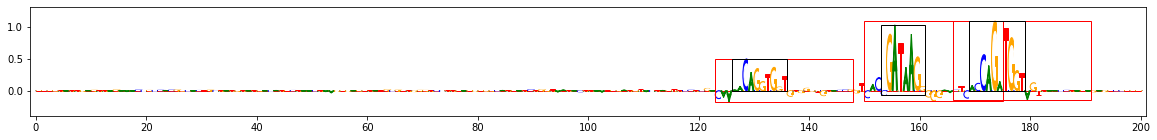

Matches to pattern 0 (the original pattern looks like this:)


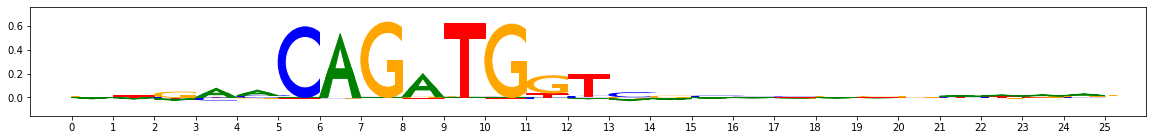

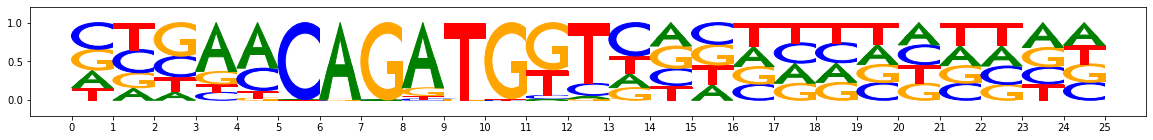

matches in this example...
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.7798247, exampleidx=0, start=123, end=148, trim_start=126, trim_end=136, is_revcomp=False, seqlet_orig_start=118, seqlet_orig_end=143, seqlet_orig_revcomp=False, aggregate_sim=0.4581297357119787, mod_delta=0.0008476696481033951, mod_precision=0.9949084145511224, mod_percentile=0.0, fann_perclasssum_perc=0.26649076517150394, fann_perclassavg_perc=0.26649076517150394)


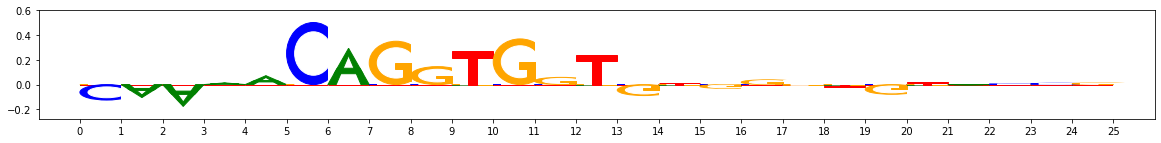

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=4.689957, exampleidx=0, start=166, end=191, trim_start=169, trim_end=179, is_revcomp=False, seqlet_orig_start=162, seqlet_orig_end=187, seqlet_orig_revcomp=False, aggregate_sim=0.5821849903811195, mod_delta=0.0008561414832002218, mod_precision=1.0, mod_percentile=0.0026385224274406704, fann_perclasssum_perc=0.7651715039577837, fann_perclassavg_perc=0.7783641160949868)


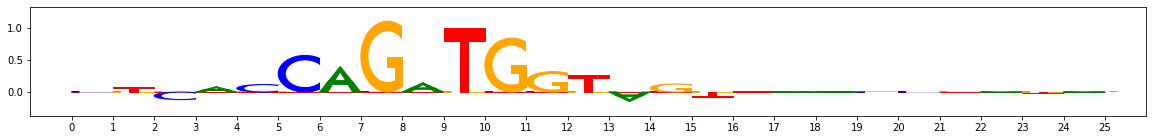

Matches to pattern 1 (the original pattern looks like this:)


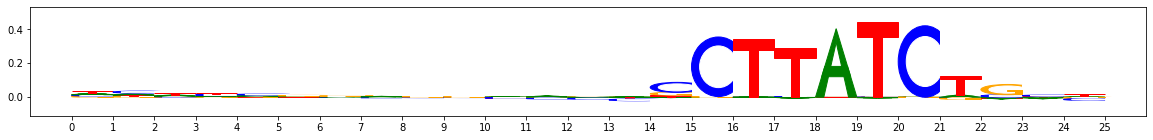

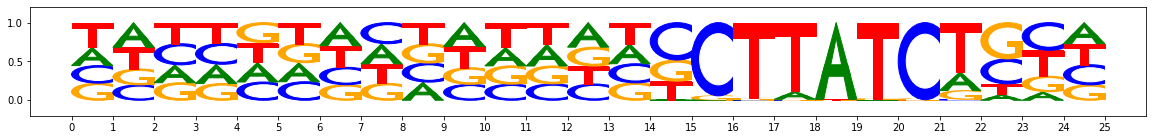

matches in this example...
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=6.649457, exampleidx=0, start=150, end=175, trim_start=153, trim_end=161, is_revcomp=True, seqlet_orig_start=145, seqlet_orig_end=170, seqlet_orig_revcomp=False, aggregate_sim=0.5634824571914402, mod_delta=0.0008702559487363602, mod_precision=1.0, mod_percentile=0.9483747609942639, fann_perclasssum_perc=0.8317399617590822, fann_perclassavg_perc=0.8221797323135756)


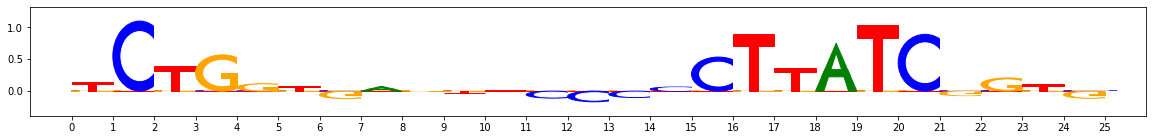

EXAMPLE IDX 1 hits:
Computing windowed sums on original
Only returning positive coords!
Got 3 coords
Original core seqlet locations


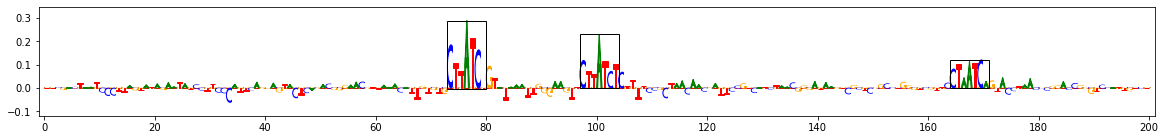

Motif matches (red = without trimming)


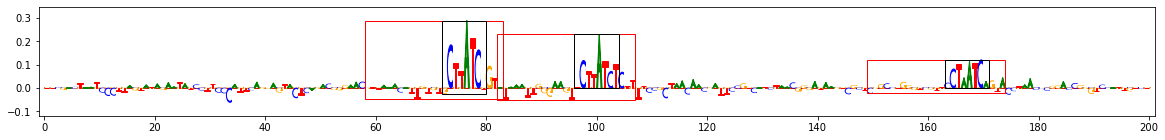

Matches to pattern 1 (the original pattern looks like this:)


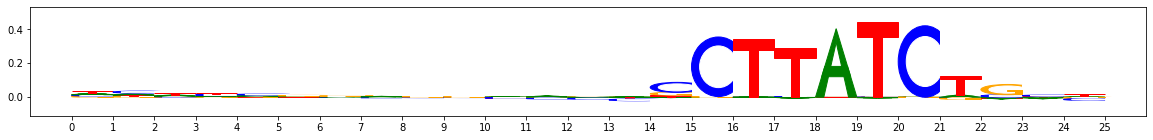

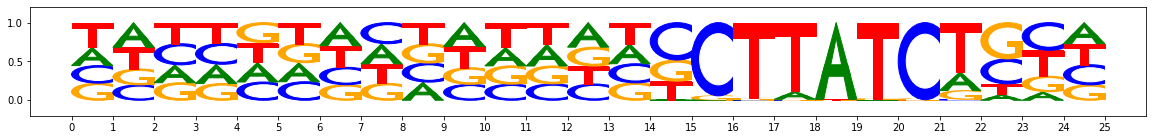

matches in this example...
MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=1.0580559, exampleidx=1, start=58, end=83, trim_start=72, trim_end=80, is_revcomp=False, seqlet_orig_start=64, seqlet_orig_end=89, seqlet_orig_revcomp=False, aggregate_sim=0.406992057613628, mod_delta=0.0006804247742920383, mod_precision=1.0, mod_percentile=0.36711281070745694, fann_perclasssum_perc=0.3059273422562141, fann_perclassavg_perc=0.46845124282982786)


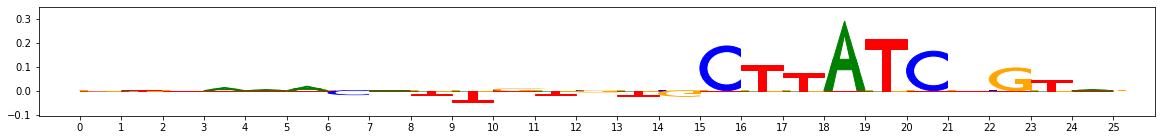

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.7735233, exampleidx=1, start=82, end=107, trim_start=96, trim_end=104, is_revcomp=False, seqlet_orig_start=88, seqlet_orig_end=113, seqlet_orig_revcomp=False, aggregate_sim=0.360851074786397, mod_delta=0.0006993031170420133, mod_precision=1.0, mod_percentile=0.378585086042065, fann_perclasssum_perc=0.19502868068833656, fann_perclassavg_perc=0.2791586998087954)


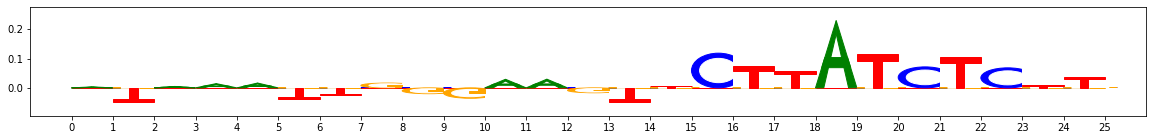

MotifMatchWithImportance(patternidx=1, patternidx_rank=0, total_importance=0.716084, exampleidx=1, start=149, end=174, trim_start=163, trim_end=171, is_revcomp=False, seqlet_orig_start=155, seqlet_orig_end=180, seqlet_orig_revcomp=False, aggregate_sim=0.33023591371419997, mod_delta=0.0007883146193581323, mod_precision=1.0, mod_percentile=0.6252390057361377, fann_perclasssum_perc=0.13001912045889097, fann_perclassavg_perc=0.14531548757170176)


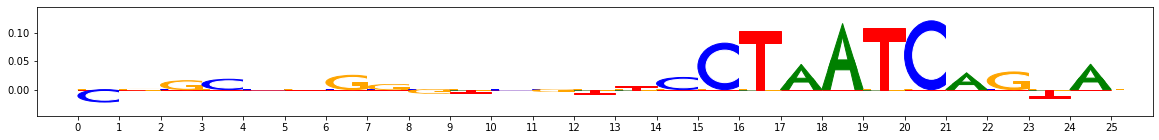

EXAMPLE IDX 2 hits:
Computing windowed sums on original
Only returning positive coords!
Got 3 coords
Original core seqlet locations


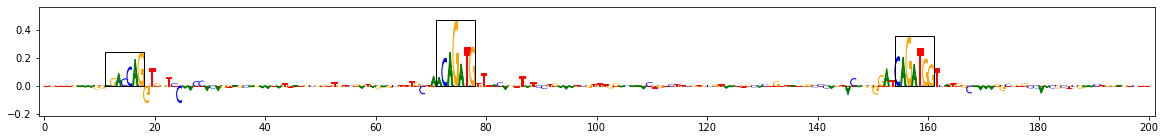

Motif matches (red = without trimming)


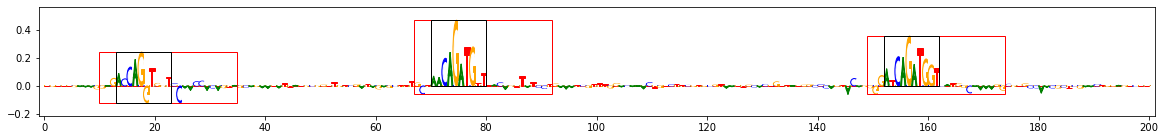

Matches to pattern 0 (the original pattern looks like this:)


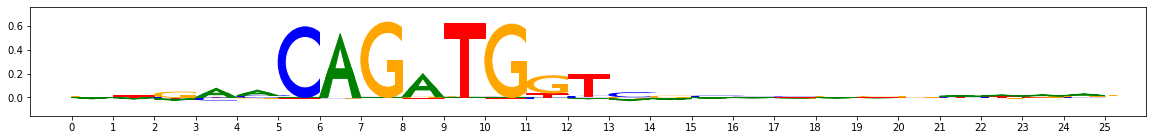

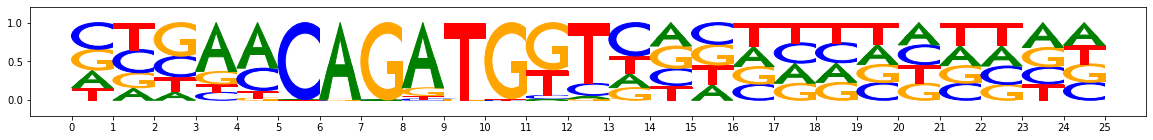

matches in this example...
MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=0.6640052, exampleidx=2, start=10, end=35, trim_start=13, trim_end=23, is_revcomp=False, seqlet_orig_start=2, seqlet_orig_end=27, seqlet_orig_revcomp=False, aggregate_sim=0.38759550907771473, mod_delta=0.00082920082265016, mod_precision=0.9739088129112974, mod_percentile=0.0, fann_perclasssum_perc=0.1108179419525066, fann_perclassavg_perc=0.1108179419525066)


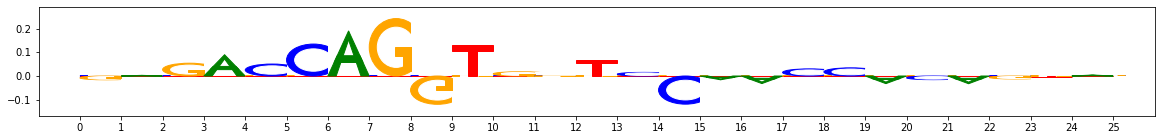

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.9246597, exampleidx=2, start=67, end=92, trim_start=70, trim_end=80, is_revcomp=False, seqlet_orig_start=62, seqlet_orig_end=87, seqlet_orig_revcomp=False, aggregate_sim=0.5541921758598762, mod_delta=0.0008440019296581307, mod_precision=0.9907381100305337, mod_percentile=0.0, fann_perclasssum_perc=0.6437994722955145, fann_perclassavg_perc=0.7097625329815304)


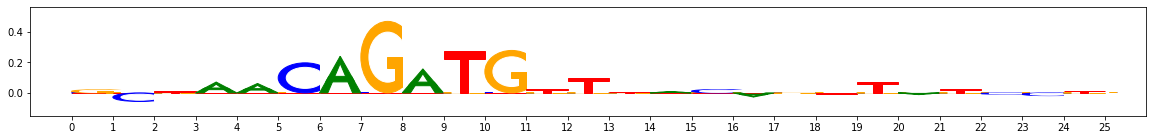

MotifMatchWithImportance(patternidx=0, patternidx_rank=0, total_importance=1.7246141, exampleidx=2, start=149, end=174, trim_start=152, trim_end=162, is_revcomp=False, seqlet_orig_start=145, seqlet_orig_end=170, seqlet_orig_revcomp=False, aggregate_sim=0.511757765684239, mod_delta=0.0008641595094941821, mod_precision=1.0, mod_percentile=0.0026385224274406704, fann_perclasssum_perc=0.5672823218997362, fann_perclassavg_perc=0.575197889182058)


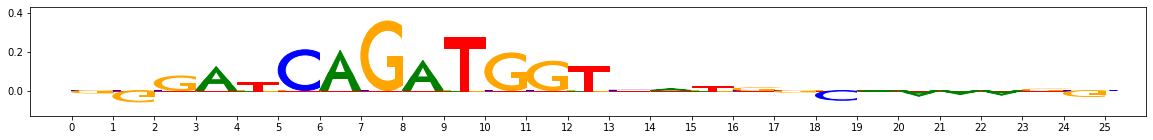

In [12]:
from modisco.visualization import viz_sequence
reload(modisco.coordproducers)

contrib_scores = task_to_scores["task0"]

#visualize the matches
for exampleidx in list(sorted(exampleidx_to_matches.keys()))[:3]: #visualizing the matches in the first 10 seqs
    
    print("EXAMPLE IDX",exampleidx,"hits:")
    matches = exampleidx_to_matches[exampleidx]
    
    coords = hit_scorer.coordproducer(score_track=np.sum(contrib_scores[exampleidx], axis=-1)[None,:],
                                     tnt_results=hit_scorer.tnt_results, null_track=None).coords
    #highlight the locations of all the matches
    print("Original core seqlet locations")
    viz_sequence.plot_weights(
        contrib_scores[exampleidx],
        highlight={'black': [
            (max(x.start+hit_scorer.coordproducer.flank,0),
             min(x.end-hit_scorer.coordproducer.flank,len(contrib_scores[exampleidx])))
             for x in coords]},
        subticks_frequency=20)
    print("Motif matches (red = without trimming)")
    viz_sequence.plot_weights(
        contrib_scores[exampleidx],
        highlight={'red': [
            (max(x.start,0), min(x.end,len(contrib_scores[exampleidx])))
             for x in matches],
                   'black': [
            (max(x.trim_start,0), min(x.trim_end,len(contrib_scores[exampleidx])))
             for x in matches]},
        subticks_frequency=20)
    
    for i in range(len(orig_patterns)):
        matches_to_pattern = [x for x in matches if x.patternidx==i]
        if (len(matches_to_pattern) > 0):
            print("Matches to pattern",i,"(the original pattern looks like this:)")
            viz_sequence.plot_weights(hit_scorer.seqlet_scorer.class_patterns[i]["task0_contrib_scores"].fwd)
            viz_sequence.plot_weights(hit_scorer.seqlet_scorer.class_patterns[i]["sequence"].fwd)
            print("matches in this example...")
            for match in matches_to_pattern:
                print(match)
                if (match.is_revcomp==False):
                    viz_sequence.plot_weights(contrib_scores[exampleidx][match.start:match.end])
                else:
                    viz_sequence.plot_weights(contrib_scores[exampleidx][match.start:match.end][::-1,::-1])

## Inspect the pattern merging hierarchy

Inspect the hierarchy of motif merging events that led to the final motif. Read "Path to node" like a directory structure; all motifs at a similar level in the hierarchy (except for the topmost level) were collapsed together. Any motifs at the topmost level for which the number of seqlets was less than `final_min_cluster_size` were disbanded, and their seqlets were reassigned to the dominant motifs (provided the similarity passed a threshold)

For metacluster 0
Path to node: root/0
Number of seqlets 590


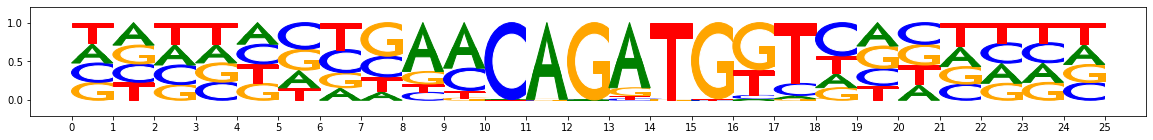

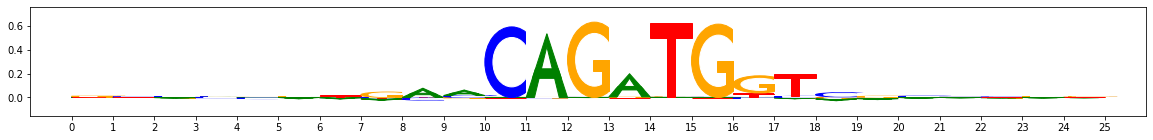

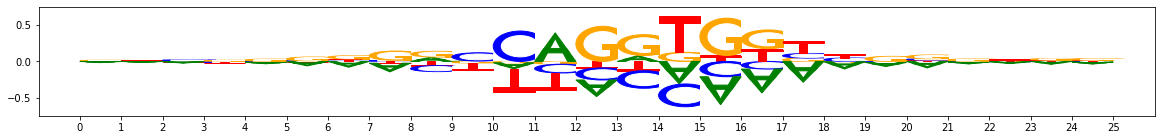

Path to node: root/0/0
Number of seqlets 543


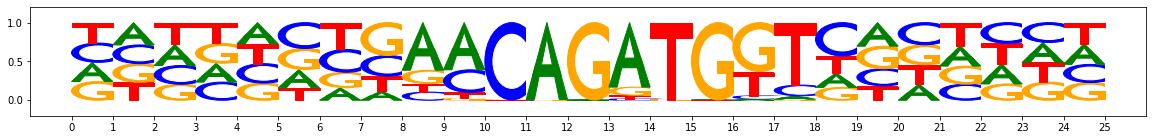

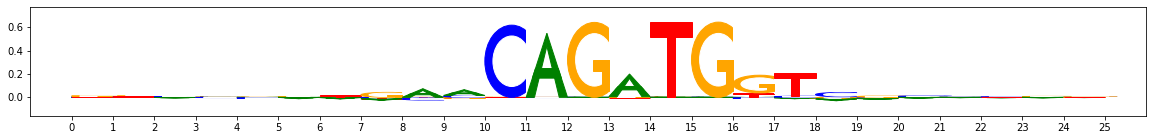

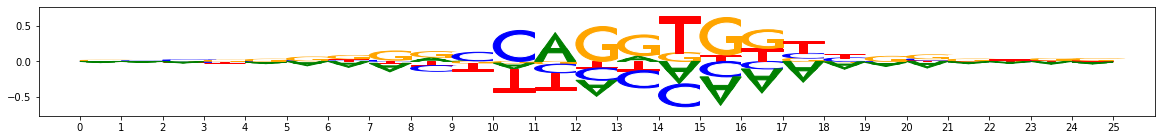

Path to node: root/0/1
Number of seqlets 20


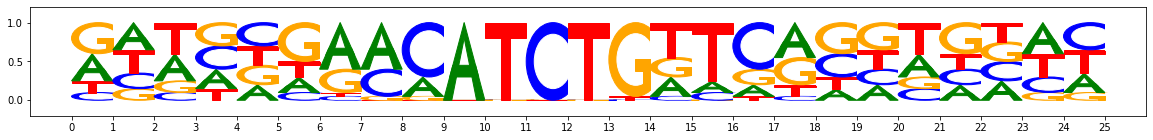

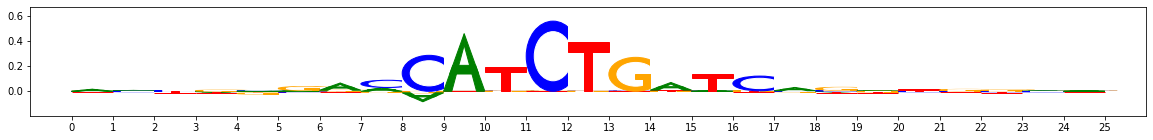

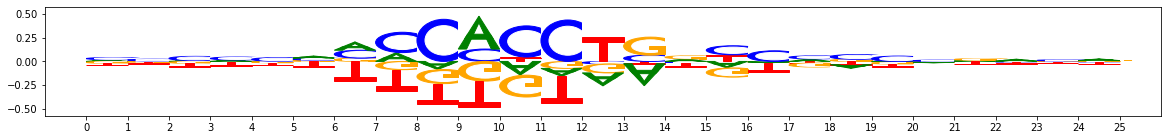

Path to node: root/0/2
Number of seqlets 22


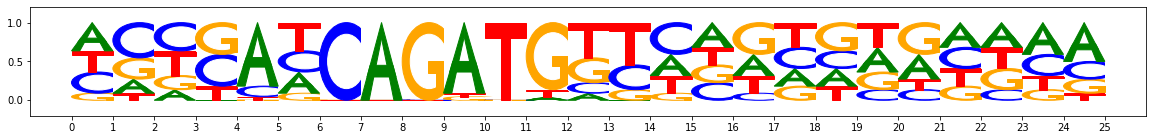

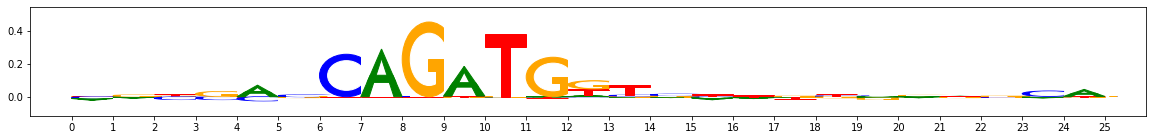

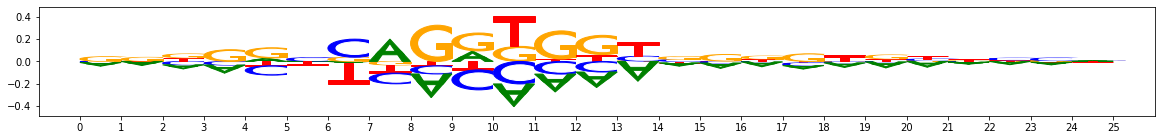

Path to node: root/0/3
Number of seqlets 5


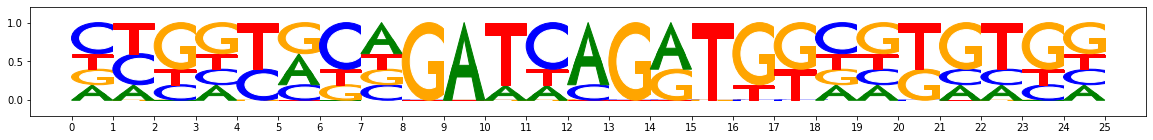

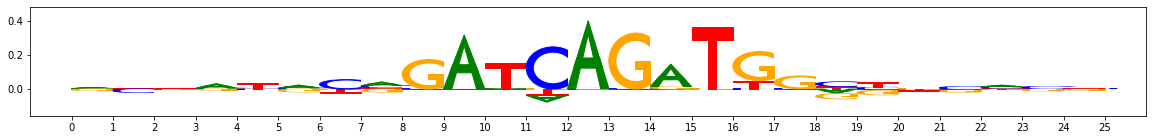

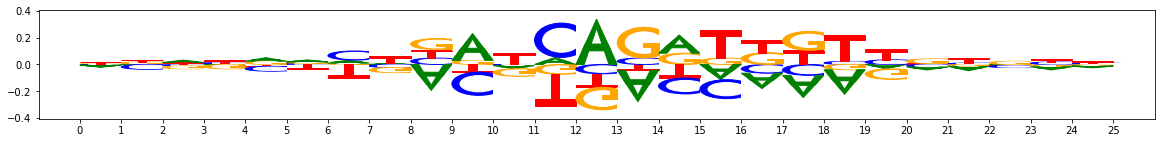

Path to node: root/1
Number of seqlets 544


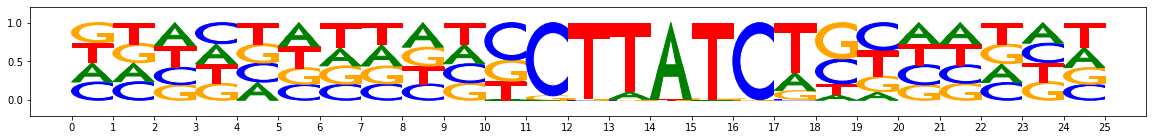

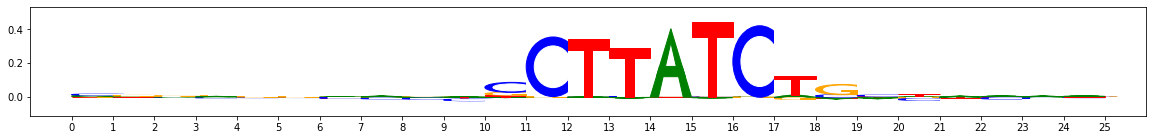

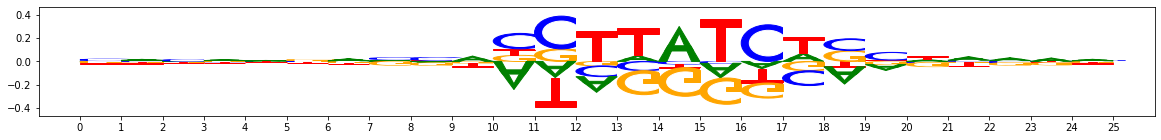

Path to node: root/1/0
Number of seqlets 287


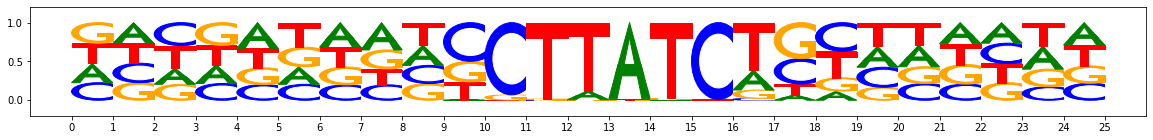

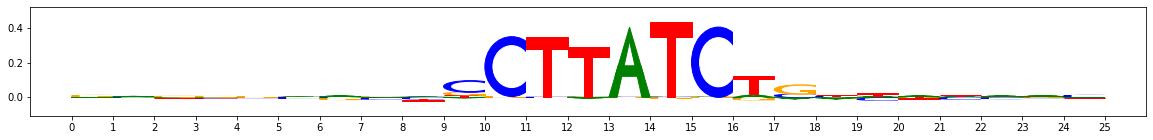

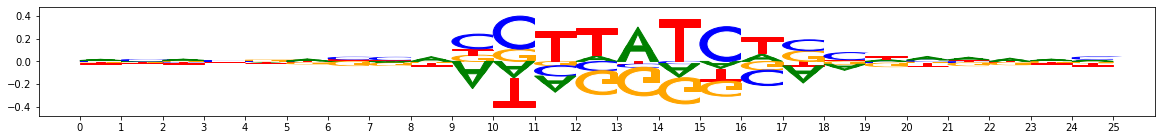

Path to node: root/1/1
Number of seqlets 257


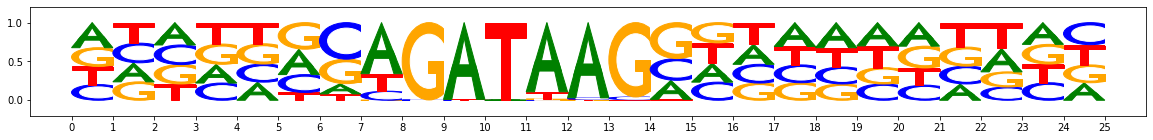

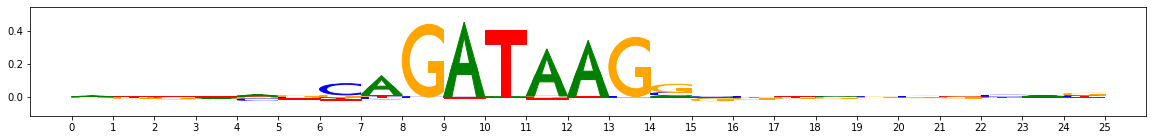

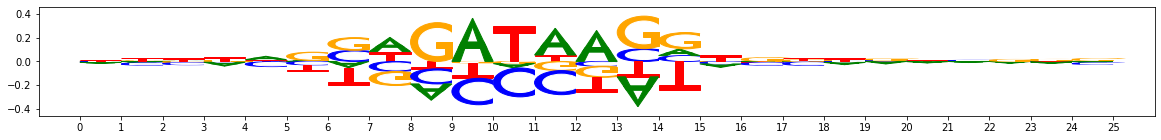

Path to node: root/2
Number of seqlets 5


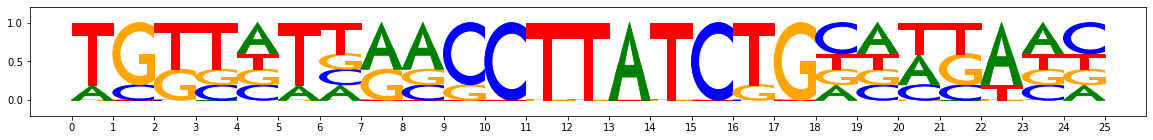

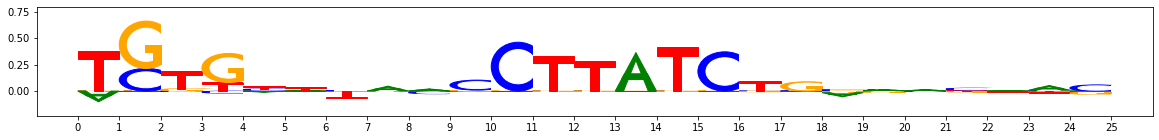

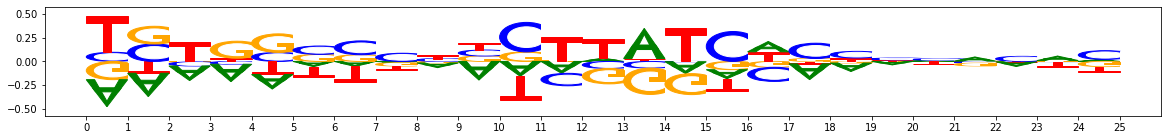

In [13]:
def recursive_plot_hierarchy_motifs(nodes, path):
    for i in range(len(nodes)):
        nodepath = path+"/"+str(i)
        print("Path to node:",nodepath)
        print("Number of seqlets",len(nodes[i].pattern.seqlets))
        if (nodes[i].indices_merged is not None):
            #indices_merged, submat_crosscontam and submat_alignersim can
            # be used to inspect the steps in the merging
            #print("indices merged:",nodes[i].indices_merged)
            #print("submat crosscontam:\n",nodes[i].submat_crosscontam)
            #print("submat alignersim:\n",nodes[i].submat_alignersim)
            pass
        
        #For plotting figures to a png, this code can be used...
        #fig = plt.figure(figsize=(20,5))                                           
        #ax = fig.add_subplot(111)
        #viz_sequence.plot_weights_given_ax(ax, nodes[i].pattern["sequence"].fwd)
        #plt.savefig(nodepath+".png")
        
        viz_sequence.plot_weights(nodes[i].pattern["sequence"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(nodes[i].pattern["task0_hypothetical_contribs"].fwd)
        recursive_plot_hierarchy_motifs(nodes[i].child_nodes, path=nodepath)

print("For metacluster 0")
recursive_plot_hierarchy_motifs(loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.pattern_merge_hierarchy.root_nodes,
    path="root")